In [1]:
import numpy as np
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

from plnn.models.algebraic_pl import AlgebraicPL
from plnn.pl import plot_phi

In [2]:
seed = 42
rng = np.random.default_rng(seed=seed)

In [3]:
OUTDIR = "out"

CASE = 1  # Use signals
# CASE = 2  # Use parameters

In [4]:
if CASE == 1:
    saveas = "phi1_evol_with_bifs"
    xlabel = "$s_1$"
    ylabel = "$s_2$"
    title = "Signals"
elif CASE == 2:
    saveas = "phi1_evol_with_bifs_ps"
    xlabel = "$p_1$"
    ylabel = "$p_2$"
    title = "Parameters"

In [5]:
model, _ = AlgebraicPL.make_model(
    key=jrandom.PRNGKey(0),
    dtype=jnp.float64,
    algebraic_phi_id="phi1",
    tilt_weights=[[1, 0],[0, 1]],
    tilt_bias=[0, 0],
    sigma_init=0.8,
    signal_type="sigmoid",
    nsigparams=4,
)

In [6]:
tilt_center = [-0.5, 0]
direction = [1., 1.]
tilt_radius = 1.2
tilt_list = [tilt_center]

tilt_center = np.array(tilt_center)
direction = np.array(direction) / np.linalg.norm(direction)

for r in np.linspace(0, tilt_radius, 20):
    p = tilt_center + r * direction
    tilt_list.append(p)

thetas = np.linspace(0, 2*np.pi, 60)
th0 = np.arctan(direction[1]/direction[0])
for th in thetas:
    p = tilt_center + tilt_radius * np.array([np.cos(th+th0), np.sin(th+th0)])
    tilt_list.append(p)

for r in np.flip(np.linspace(0, tilt_radius, 20)):
    p = tilt_center + r * direction
    tilt_list.append(p)

tilt_list = np.array(tilt_list, dtype=np.float64)

In [8]:
from plnn.helpers import get_phi1_fixed_points

fixed_points = get_phi1_fixed_points(tilt_list)

In [17]:
from cont.binary_choice import get_binary_choice_curves

bifcurves, bifcolors = get_binary_choice_curves()

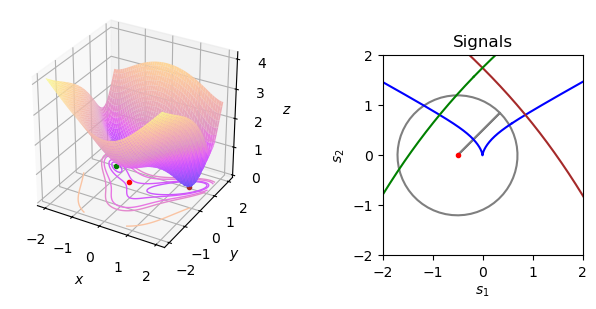

In [28]:
# Initialize the figure and axis object
fig = plt.figure(figsize=(7,5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.view_init(50, -60)

left, bottom, width, height = 0.6, 0.25, 0.4, 0.4
ax2 = fig.add_axes([left, bottom, width, height])
ax2.plot(tilt_list[:,0], tilt_list[:,1], 'k', alpha=0.5)
ax2.set_aspect('equal')
tilt_marker, = ax2.plot(tilt_list[0,0], tilt_list[0,1], 'r.')
ax2.set_xlabel(xlabel)
ax2.set_ylabel(ylabel)
ax2.set_title(title)
ax2.set_xlim([-2, 2])
ax2.set_ylim([-2, 2])

for curve, col in zip(bifcurves, bifcolors):
    ax2.plot(curve[:,0], curve[:,1], color=col)

def update(i):
    ax1.cla()  # Clear the current plot
    plot_phi(
        model,
        r=2,
        plot3d=True,
        tilt=tilt_list[i],
        res=200,
        equal_axes=True,
        include_cbar=False,
        title="",
        cbar_title="$\ln\phi$",
        show=True,
        view_init=(50, -60),
        ax=ax1,
        tight_layout=False,
        ncontours=5,
    )
    fp_values, fp_types, fp_colors = [v[i] for v in fixed_points]
    for k in range(len(fp_values)):
        ax1.plot(
            *fp_values[k], '.',
            color=fp_colors[k],
        )

    tilt_marker.set_xdata([tilt_list[i, 0]])
    tilt_marker.set_ydata([tilt_list[i, 1]])


ani = FuncAnimation(fig, update, frames=len(tilt_list), interval=50)

In [29]:
HTML(ani.to_html5_video())

In [ ]:
ani.save(f"{OUTDIR}/{saveas}.mp4");